## Online
### 一、背景介绍  
    1.1 背景
    1.2 问题
    1.3 数据
    1.4 评测
### 二、探索性数据分析  
    2.1 读取店铺信息数据
    2.2 店铺数据详细信息
    2.3 读取支付数据
    2.4 单个商家客流量的走势图
### 三、ARIMA模型  
    3.1 支付记录统计
    3.2 绘制差分图
    3.3 平稳性检验
    3.4 模型定阶
    3.5 模型训练
    3.6 模型预测
    3.7 模型评测
### 四、时间序列加权回归模型  
    4.1 最优常数回归模型  
	4.2 时间加权回归模型  
	4.3 周期、天气因素思考
### 五、回归树模型
	5.1 读取数据
	5.2 特征工程
        5.2.1 数据统计
        5.2.2 缺失数据填补
        5.2.3 数据平滑
    5.3 构造训练样本
    5.4 构造目标变量
	5.5 数据拆分
	5.6 模型构建
    5.7 模型评测
### 六、其他解决方案
	7.1 相似历史片段预测填充法
	7.2 模型融合
### 七、总结

# 一、背景介绍


### 1.1 背景 Background
#### 口碑致力于为每个商家提供销售预测。基于预测结果，商家可以优化运营，降低成本，并改善用户体验。

从2015.07.01到2016.10.31（除去2015.12.12）的商家数据，用户支付行为数据以及用户浏览行为数据。预测测试集中所有商家在未来14天（2016.11.01-2016.11.14）内各自每天（00:00:00-23:59:59）的客户流量。


### 1.2 问题 Statement
预测客户流量对商家的经营管理至关重要。在口碑平台上，将客户流量定义为“单位时间内在商家使用支付宝消费的用户人次”。在这个问题中，将利用提供的用户浏览和支付历史，以及商家相关信息，以此预测所有商家在接下来14天内，每天的客户流量。  
额外数据可考虑使用：类似天气等额外的数据。

### 1.3 数据 Data
user_pay, 69,674,110 条大约2.1G 用户支付行为数据；
5,556,715 条大约174M 用户浏览行为数据和2000 个商家信息数据，参赛选手可以自由使用天气数据。预测未来14 天每个商家每天的支付流量，其中1000 个商家用于A 榜测试，另外1000 个商家用户B 榜测试。

#### user_pay表
<img src="./img/user_pay.png" width = "400" height = "280" alt="图片名称" align=left />

#### user_view表
<img src="./img/user_view.png" width = "400" height = "300" alt="图片名称" align=left />

#### shop_info表
<img src="./img/shop_info.png" width = "600" height = "400" alt="图片名称" align=left />

### 1.4 评测 Evaluation
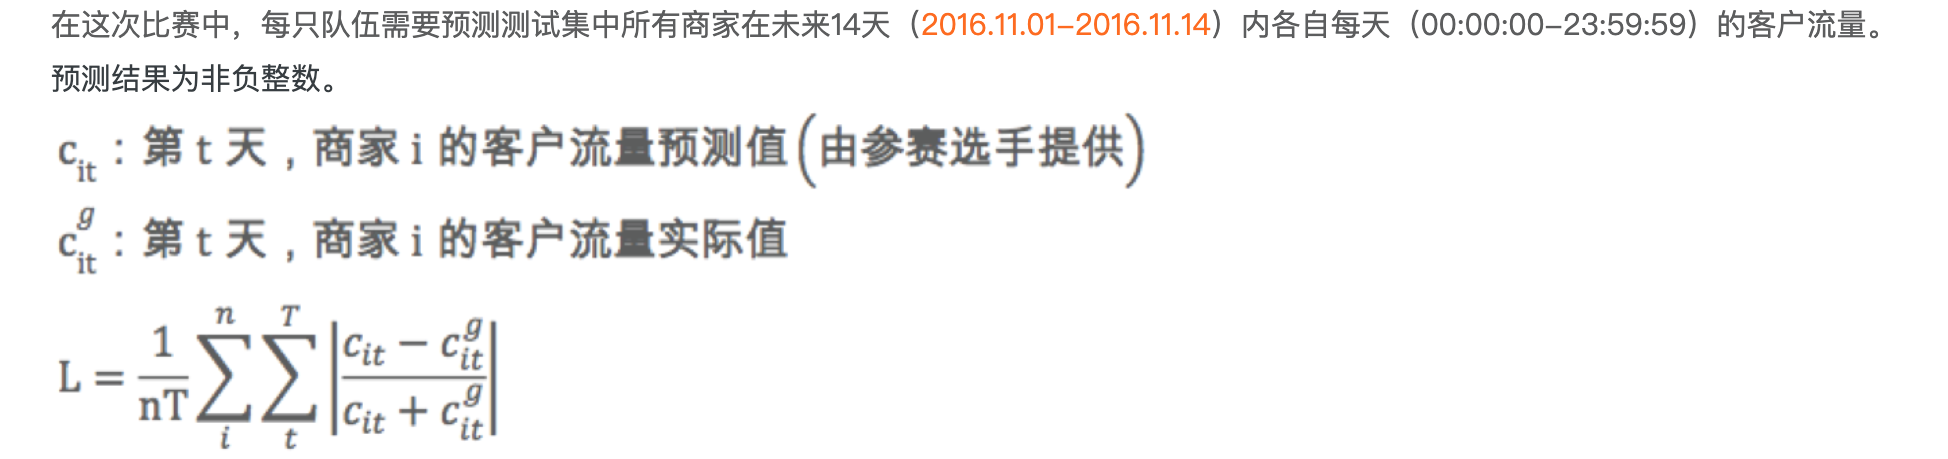

# 二、描述性统计分析

    场景中设计到总的商店个数为2000家，支付记录包括6967,4110条，数据量较大不利于授课实战，因此从2000家随机抽样100家作为案例，整个分析、建模的过程完全一致。

### 2.1 读取店铺信息数据

In [1]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

shop_info = pd.read_csv('data/dataset/shop_info.txt',
                names=['shop_id','city_name','location_id','per_pay','score','comment_cnt', 'shop_level','cate_1_name','cate_2_name','cate_3_name'])
shop_info.head()

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
0,1,湖州,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点
1,2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,NaN
2,3,南昌,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶
3,4,天津,380,18,NaN,NaN,1,超市便利店,超市,NaN
4,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果


### 2.2 店铺数据详细信息

In [2]:
shop_info.describe(include='all')

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
count,2000.000000,2000,2000.000000,2000.000000,1709.000000,1709.000000,2000.000000,2000,2000,1415
unique,NaN,122,NaN,NaN,NaN,NaN,NaN,6,17,43
top,NaN,上海,NaN,NaN,NaN,NaN,NaN,美食,快餐,西式快餐
freq,NaN,285,NaN,NaN,NaN,NaN,NaN,1415,639,405
mean,1000.500000,NaN,583.083000,10.479000,2.677004,3.130486,0.814500,NaN,NaN,NaN
std,577.494589,NaN,335.763357,5.762479,1.024211,3.499072,0.855836,NaN,NaN,NaN
min,1.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,500.750000,NaN,287.750000,5.000000,2.000000,1.000000,0.000000,NaN,NaN,NaN
50%,1000.500000,NaN,577.500000,10.000000,3.000000,2.000000,1.000000,NaN,NaN,NaN
75%,1500.250000,NaN,877.250000,15.000000,3.000000,4.000000,2.000000,NaN,NaN,NaN


In [3]:
shop_info.dtypes # 检查数据类型[有些数据是离散数值型的，需要和字符型字段区分开]。

shop_id          int64
city_name       object
location_id      int64
per_pay          int64
score          float64
comment_cnt    float64
shop_level       int64
cate_1_name     object
cate_2_name     object
cate_3_name     object
dtype: object

In [4]:
shop_info['city_name'].value_counts()[:20]

上海    285
杭州    225
北京    163
广州    136
南京    130
武汉    124
深圳     88
温州     67
苏州     66
宁波     45
福州     41
成都     37
厦门     30
绍兴     30
无锡     26
济南     24
青岛     23
金华     23
合肥     21
常州     20
Name: city_name, dtype: int64

In [4]:
shop_info['cate_2_name'].value_counts()

快餐             639
超市             372
便利店            206
休闲茶饮           177
小吃             156
休闲食品           150
烘焙糕点           122
中餐              78
其他美食            44
火锅              33
烧烤               9
汤/粥/煲/砂锅/炖菜      7
药店               2
网吧网咖             2
个人护理             1
美容美发             1
本地购物             1
Name: cate_2_name, dtype: int64

### 2.3 读取支付数据

In [5]:
user_pay = pd.read_csv('data/dataset/user_pay.txt', names=['user_id','shop_id','time_stamp'] )
print (user_pay.shape)

(69674110, 3)


In [6]:

user_pay_copy = user_pay[user_pay['shop_id'].isin([1022, 1912])]
user_pay_copy['dt'] = user_pay_copy['time_stamp'].apply(lambda x:x[:10]) # 特征工程-取具体的时间【天】
print (user_pay_copy.shape)


(93912, 4)


###  2.4 单个商家客流量的走势图

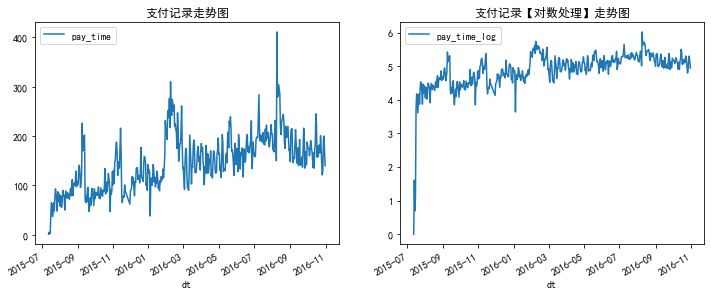

In [10]:

def stat_shop_pay_time(shop_id, user_pay):
    dta = user_pay[user_pay['shop_id']==shop_id] #取特定的shop_id数据
    dtFreq = dta.groupby('dt')['user_id'].count() # 按照dt统计对应的支付记录次数
    dtFreq = pd.DataFrame({'dt':dtFreq.index, 'pay_time':dtFreq.values})
    dtFreq.index = pd.to_datetime(dtFreq.dt)
    dtFreq['pay_time_log'] = dtFreq['pay_time'].apply(lambda x:np.log(x))
    del dtFreq['dt']
    return dtFreq

def draw_trend(data):

    # 绘制差分图
    fig = plt.figure(figsize=(12,10))
    ax1= fig.add_subplot(2,2,1)
    data[['pay_time']].plot(ax=ax1)
    plt.title('支付记录走势图')

    ax2= fig.add_subplot(2,2,2)
    data[['pay_time_log']].plot(ax=ax2)
    plt.title('支付记录【对数处理】走势图')
    
    plt.show()
    
shop_id = 1912
count_user_pay = stat_shop_pay_time(shop_id, user_pay_copy)
draw_trend(count_user_pay)

## 三、ARIMA

In [11]:

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller


### 3.1 支付记录统计

In [12]:
count_user_pay = stat_shop_pay_time(shop_id, user_pay_copy)
count_user_pay.head()

,pay_time,pay_time_log
dt,,
2015-07-13,1,0.000000
2015-07-14,5,1.609438
2015-07-15,2,0.693147
2015-07-16,3,1.098612
2015-07-17,41,3.713572


In [13]:
train = count_user_pay[['pay_time_log']]

### 3.2 绘制差分图

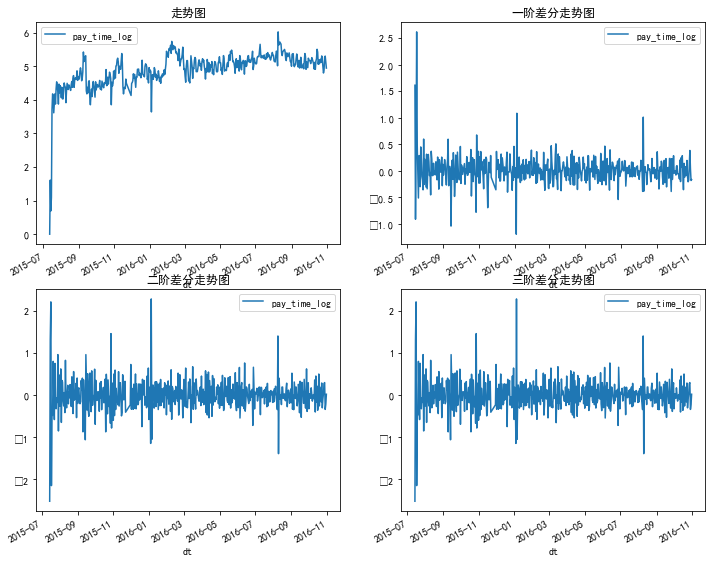

In [14]:

def draw_diff(data):
    
    # 绘制差分图
    fig = plt.figure(figsize=(12,10))
    ax1= fig.add_subplot(2,2,1)
    data.plot(ax=ax1)
    plt.title('走势图')

    ax2= fig.add_subplot(2,2,2)
    diff1 = data.diff(1).dropna()
    diff1.plot(ax=ax2)
    plt.title('一阶差分走势图')
    
    ax3= fig.add_subplot(2,2,3)
    diff2 = data.copy()
    for i in range(2):
        diff2 = diff2.diff(1).dropna()
    diff2.plot(ax=ax3)
    plt.title('二阶差分走势图')
    
    ax4= fig.add_subplot(2,2,4)
    diff3 = data.copy()
    for i in range(2):
        diff3 = diff3.diff(1).dropna()
    diff3.plot(ax=ax4)
    plt.title('三阶差分走势图')
    
    plt.show()
    
draw_diff(train)

### 3.3 平稳性检验 (ADF TEST)
p值越小，说明能拒绝原假设。在0.05置信度下，判断数据是稳定的。

In [15]:
trainDf = train[-60:-14].copy()

In [16]:

def teststationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

teststationarity(trainDf.diff(1).dropna()['pay_time_log'])


Test Statistic                -6.049698e+00
p-value                        1.286392e-07
#Lags Used                     5.000000e+00
Number of Observations Used    3.900000e+01
Critical Value (1%)           -3.610400e+00
Critical Value (5%)           -2.939109e+00
Critical Value (10%)          -2.608063e+00
dtype: float64

### 3.4 模型定阶

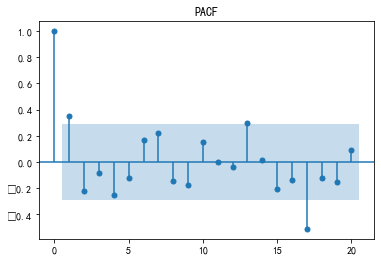

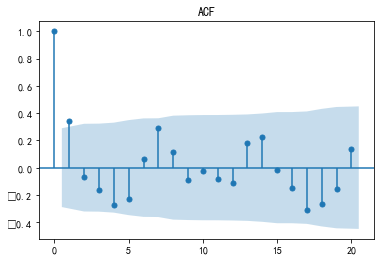

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def draw_pacf_acf(data):
    
    # 一阶差分分析 PACF ARIMA(p，d，q)---> p
    pacf = plot_pacf(data, lags=20)  # 通过plot_pacf来查看训练数据，以便我们判断p的取值
    plt.title("PACF")
    pacf.show()
    
    # 一阶差分分析 ACF ARIMA(p，d，q)---> q
    acf = plot_acf(data, lags=20)  # 通过plot_acf来查看训练数据，以便我们判断q的取值
    plt.title("ACF")
    acf.show()
    
draw_pacf_acf(trainDf.dropna())


### 3.5 模型训练

In [18]:

model = ARIMA(trainDf.dropna(), order=(2,1,2))  # pdq 
arima_result = model.fit()


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


### 3.6 预测

In [19]:

rs = arima_result.predict('2016-10-18','2016-10-31',dynamic=True)  # 输入预测参数
rs


2016-10-18   -0.087071
2016-10-19    0.031741
2016-10-20    0.076168
2016-10-21    0.062656
2016-10-22    0.026596
2016-10-23   -0.003783
2016-10-24   -0.017074
2016-10-25   -0.015606
2016-10-26   -0.007468
2016-10-27    0.000176
2016-10-28    0.003987
2016-10-29    0.004098
2016-10-30    0.002312
2016-10-31    0.000418
Freq: D, dtype: float64

In [20]:

vlStart = train['pay_time_log'][-15]
infos = []
w = vlStart
for dt, vl in zip(rs.index, rs):
    infos.append({
        'dt':dt,
        'p':np.exp(w+vl)
    })
    w+=vl
infos = pd.DataFrame(infos)
infos.index = infos['dt']
del infos['dt']

infos


,p
dt,
2016-10-18,143.908031
2016-10-19,148.549117
2016-10-20,160.305924
2016-10-21,170.671443
2016-10-22,175.271577
2016-10-23,174.609712
2016-10-24,171.653804
2016-10-25,168.995823
2016-10-26,167.738447


In [21]:
dev = count_user_pay[-14:]
dev['pay_time'] = dev['pay_time_log'].apply(lambda x:np.exp(x))
dev.head()

,pay_time,pay_time_log
dt,,
2016-10-18,180.0,5.192957
2016-10-19,159.0,5.068904
2016-10-20,169.0,5.129899
2016-10-21,182.0,5.204007
2016-10-22,166.0,5.111988


### 3.7 展示预测的可视化结果

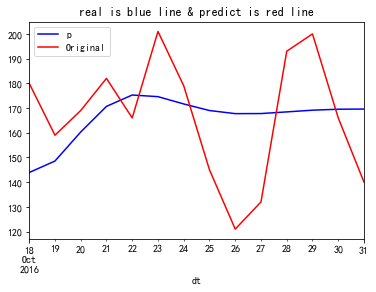

In [22]:

ts = infos.index  # 过滤没有预测的记录plt.figure(facecolor='white')
infos.plot(color='blue', label='Predict')
dev['pay_time'].plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('real is blue line & predict is red line')
plt.show()


### 3.8 模型评测

In [23]:

L = 0
for p,t in zip(infos['p'], dev['pay_time']):
    L += abs(p-t)/(p+t)
print(L/14)


0.06697033471527612
